## Importing working packages

In [255]:
import pandas as pd
import time
from datetime import datetime
from datetime import datetime
from collections import Counter
import os
import numpy as np
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, MaxPooling1D, Conv1D, Flatten, Concatenate, concatenate, Input
from tensorflow.keras.layers import BatchNormalization, Bidirectional, Input, LocallyConnected1D, Activation
from tensorflow.keras.layers import LSTM, GRU, TimeDistributed, GaussianDropout, AlphaDropout, GaussianNoise
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adamax, Adadelta
from tensorflow.keras.utils import plot_model

#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

import matplotlib.pyplot as plt
import math

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import scipy



import warnings
warnings.filterwarnings("ignore")
warnings.warn("deprecated", DeprecationWarning)
import sys

# Data preprocessing

## Preprocessing methods

In [1141]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    input_data = input_data.copy()
     # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
 
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
 
    return data_msc

In [443]:
def snv(input_data):
    """
    Performs a Standard Normal Variate (SNV) correction.
    
    """
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [626]:
def detrend(spectra, bp=0):
    """ Perform spectral detrending to remove linear trend from data.
    Args:
        spectra <numpy.ndarray>: NIRS data matrix.
        bp <list>: A sequence of break points. If given, an individual linear fit is performed for each part of data
        between two break points. Break points are specified as indices into data.
    Returns:
        spectra <numpy.ndarray>: Detrended NIR spectra
    """
    return scipy.signal.detrend(spectra,axis=0, bp=bp)

In [139]:
import scipy.signal
import scipy.io as io
import scipy.ndimage as nd
import numpy as np
from sklearn.preprocessing import normalize, scale


In [1421]:
def smooth(spectra, filter_win=11, window_type='flat', mode='reflect'):
    """ Smooths the spectra using convolution.
    Args:
        spectra <numpy.ndarray>: NIRS data matrix.
        filter_win <float>: length of the filter window in samples.
        window_type <str>: filtering window to use for convolution (see scipy.signal.windows)
        mode <str>: convolution mode
    Returns:
        spectra <numpy.ndarray>: Smoothed NIR spectra.
    """

    if window_type == 'flat':
        window = np.ones(filter_win)
    else:
        window = scipy.signal.windows.get_window(window_type, filter_win)
    window = window / np.sum(window)

    for row in range(spectra.shape[0]):
        spectra[row,:] = nd.convolve(spectra[row,:], window, mode=mode)

    return spectra

In [1547]:
def savgol(spectra, filter_win=15, poly_order=2, deriv_order=0, delta=1.0):
    """ Perform Savitzky–Golay filtering on the data (also calculates derivatives). This function is a wrapper for
    scipy.signal.savgol_filter.

    Args:
        spectra <numpy.ndarray>: NIRS data matrix.
        filter_win <int>: Size of the filter window in samples (default 11).
        poly_order <int>: Order of the polynomial estimation (default 3).
        deriv_order <int>: Order of the derivation (default 0).

    Returns:
        spectra <numpy.ndarray>: NIRS data smoothed with Savitzky-Golay filtering
    """
    return scipy.signal.savgol_filter(spectra, filter_win, poly_order, deriv_order, delta=delta, axis=1)

In [53]:
def derivate(spectra, order=1, delta=1):
    """ Computes Nth order derivates with the desired spacing using numpy.gradient.
    Args:
        spectra <numpy.ndarray>: NIRS data matrix.
        order <float>: Order of the derivation.
        delta <int>: Delta of the derivate (in samples).

    Returns:
        spectra <numpy.ndarray>: Derivated NIR spectra.
    """
    for n in range(order):
        spectra = np.gradient(spectra, delta, axis=1)
    return spectra

In [1560]:
def preprocess(x):
    
  #Then compute first derivative
  #x = derivate(x,order=2)
  #Apply a Savitzky-Golay filter
  #x = savgol(x)
    
  # Smooth data
  #x = smooth(x)

  #Then compute first derivative
  x = derivate(x)
    
  #Perform SNV
  #x = snv(x)
    
  #Detrend the signal
  #x = detrend(x)
  
  return x

In [1549]:
from scipy.stats import pearsonr

In [56]:
def plot_spectra(wl,spectra):
    plt.figure(figsize=(8,9))
    with plt.style.context(('ggplot')):
        plt.plot(wl, spectra)
        plt.title('Original data')

In [57]:
def weight_predictors(x,y):
  wls = np.array([int(l) for l in x.columns])

  data = pd.DataFrame(x.to_numpy(),columns=wls)
  important_factors = []

  M = len(wls)

  corr_xy = data.apply(lambda x: x.corr(y),axis=0)
  corr_xx = data.corr()

  for wl in wls:
    a = corr_xy[wl]
    b = corr_xx[wl].sum()

    result = M * (a / b)

    important_factors.append(result)
  
  weighted_data = data.to_numpy()
  # for i in range(data.shape[1]):
  #   weighted_data[:,i] *= important_factors[i]
  weight_data =  np.diag(np.array(important_factors)) * data.to_numpy()
  weighted_x = weighted_data

  return weighted_x


In [1576]:

def load_data(fname=None, target=None, sensor=None):
  if sensor=="hone_ag":
    d = pd.read_csv(fname, sep=";")
    
  if sensor=="foss":
    d = pd.read_csv(fname, sep=";")
  

  # Convert Protein to float
  #d[target] = pd.to_numeric(d[target], errors='coerce', downcast='float')

  #Gather response and predictors in dataframe
  #d_corr = pd.concat([d["Species"].to_frame(), d[target].to_frame(), d.loc[:,'1350.155463':]], axis = 1)

  # Delete na
  #d_corr = d_corr.dropna(axis=0)

  train = d[d['Set']=='Training']
  test = d[d['Set']=='Validation']
  #train, test = train_test_split(d, test_size=0.2, random_state=42, shuffle=True)
  #export shuffled data
  #train['Set']='Training'
  #test['Set']='Validation'
  #new=pd.concat([train,test],axis=0)
  #new.to_excel('./data/shuffled_multicereal_evt5_2021.xlsx',index=False)

  #Build predictors
  if sensor=="hone_ag":
      x_train = train.loc[:,'1350.1554633964':] 
      #xcolnames = x_train.columns
      x_test = test.loc[:,'1350.1554633964':]
    
  elif sensor=="foss":
      x_train = train.loc[:,'400':] 
      #xcolnames = x_train.columns
      x_test = test.loc[:,'400':]

  #Extract targets
  y_train = train[target]
  y_test = test[target]

  #Create weighted predictors based on feature importance
  # x_train = weight_predictors(x_train,y_train)
  # x_test = weight_predictors(x_test,y_test)

  #Extract sample metadata from test set
  if sensor=="hone_ag":
        train_set_metadata = train[["Record Name"]]
        test_set_metadata = test[["Record Name"]]
  else:
        train_set_metadata = train[["Species2","Record Name"]]
        test_set_metadata = test[["Species2","Record Name"]]
    

  #Apply preprocessing operations
  x_train = preprocess(x_train)
  x_test = preprocess(x_test)

  #Convert to numpy arrays
  y_train = y_train.to_numpy()
  y_test = y_test.to_numpy()

  #Minmax Normalization of x and y
  xscaler = MinMaxScaler(feature_range=(0.1,0.9))
  x_train = xscaler.fit_transform(x_train)
  x_test = xscaler.transform(x_test)


  yscaler = MinMaxScaler(feature_range=(0.1,0.9))
  y_train = yscaler.fit_transform(y_train.reshape(-1,1))
  y_test = yscaler.transform(y_test.reshape(-1,1))
 


  ##Reshaping arrays
  x_train,x_test = np.expand_dims(x_train,axis=2),np.expand_dims(x_test,axis=2)
  #y_train,y_test = y_train.reshape(-1,1),y_test.reshape(-1,1)

      
  return x_train, y_train, x_test, y_test,yscaler, train_set_metadata, test_set_metadata

## Definition of deep learning models

In [1343]:
from keras.regularizers import l1,l2

In [1344]:
#Define a deep belief network for feature extraction
#from dbn.models import UnsupervisedDBN

In [1345]:
def dbn_feature_extraction(x_train,y_train,x_test):
  """
    Reduce dimensionality using deep belief net
  """
  dbn_model = UnsupervisedDBN(hidden_layers_structure=[100,100],
                      batch_size=120,
                      learning_rate_rbm=0.01,
                      n_epochs_rbm=100,
                      activation_function='sigmoid')
  
  x_train = dbn_model.fit_transform(x_train,y_train)
  x_test = dbn_model.transform(x_test)

  return x_train,x_test

In [1346]:

def denseModel(feature_count, x_dim):
    model = Sequential()
    model.add(Dropout(0.02, input_shape=(feature_count, x_dim)))
    model.add(GaussianDropout(0.3, input_shape=(feature_count, x_dim)))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Flatten())
    return model


inputs_layers = []
encoded_models = []
input_data = []

def convModel(feature_count, x_dim):
    model = Sequential()
    model.add(Dropout(0.002, input_shape=(feature_count, x_dim)))
    # model.add(GaussianDropout(0.2))
    # model.add(GaussianNoise(0.2))
    model.add(Conv1D (filters=32, kernel_size=15, strides=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout1D(0.02))
    
    model.add(Conv1D (filters=64, kernel_size=15, strides=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout1D(0.02))
    
    model.add(Conv1D (filters=128, kernel_size=15, strides=1, activation='relu'))
    model.add(SpatialDropout1D(0.02))
    model.add(BatchNormalization())
    
    model.add(Conv1D (filters=256, kernel_size=15, strides=1, activation='relu'))
    model.add(SpatialDropout1D(0.2))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(100, kernel_regularizer=l1(1e-7), bias_regularizer=l1(1e-7), activation='relu'))


    model.add(Dense(1,activation='linear'))
    return model


def convModel2(feature_count,x_dim):
    model = Sequential()
    model.add(Dropout(0.002, input_shape=(feature_count, x_dim)))
    model.add(Conv1D(filters=24, kernel_size=15, use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2,strides=1))
    model.add(SpatialDropout1D(0.02))

    model.add(Conv1D(filters=48,kernel_size=15 , use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2, strides=1))
    model.add(SpatialDropout1D(0.02))

    model.add(Conv1D(filters=96,kernel_size=15, use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2,strides=1))
    model.add(SpatialDropout1D(0.02))


    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l1(1e-7), bias_regularizer=l1(1e-7)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    
    model.add(Dense(128, kernel_regularizer=l1(1e-7), bias_regularizer=l1(1e-7)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.02))

    model.add(Dense(1,activation='sigmoid'))
    return model





In [1347]:
def convModel3(feature_count,x_dim):
    model = Sequential()
    model.add(Dropout(0.002, input_shape=(feature_count, x_dim)))
    model.add(Conv1D(filters=16, kernel_size=5, use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2,strides=1))
    model.add(SpatialDropout1D(0.02))

    model.add(Conv1D(filters=36,kernel_size=15 , use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2, strides=1))
    model.add(SpatialDropout1D(0.02))

    model.add(Conv1D(filters=56,kernel_size=20, use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2,strides=1))
    model.add(SpatialDropout1D(0.02))


    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l1(1e-7), bias_regularizer=l1(1e-8)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))


    
    model.add(Dense(128, kernel_regularizer=l1(1e-7), bias_regularizer=l1(1e-8)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dense(1,activation='sigmoid'))
    return model

In [1348]:
def convModel4(feature_count,x_dim):
    model = Sequential()
    model.add(Conv1D(filters=24, input_shape=(feature_count, x_dim), kernel_size=20, use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2,strides=1))

    model.add(Conv1D(filters=48,kernel_size=20 , use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=5, strides=1))

    model.add(Conv1D(filters=96,kernel_size=20, use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=5,strides=1))
    
    model.add(Conv1D(filters=192,kernel_size=20, use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=5,strides=1))
    model.add(Dropout(0.4))


    model.add(Flatten())
    model.add(Dense(100, kernel_regularizer=l1(1e-7), bias_regularizer=l1(1e-7)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))

    model.add(Dense(1,activation='sigmoid'))
    return model

In [1349]:
def convModel5(feature_count,x_dim):
    model = Sequential()
    model.add(Conv1D(filters=8, input_shape=(feature_count, x_dim), kernel_size=10, use_bias=False, strides=5, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=3,strides=2))

    model.add(Conv1D(filters=32,kernel_size=4 , use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=3, strides=2))

    model.add(Conv1D(filters=64,kernel_size=5, use_bias=False, strides=2, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=3,strides=2))
    


    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    return model

In [1350]:
def add_model(generator, data, feature_count, dim):
    model = generator(feature_count, dim)
    input_layer = Input(shape = (feature_count, dim))
    encoded_model = model(input_layer)
    inputs_layers.append(input_layer)
    encoded_models.append(encoded_model)
    input_data.append(data)

## Prepare data, models and train 

In [1577]:
fn = './data/foss_reference_data.csv'

In [1578]:
target = "Protein"
sensor = None
if "foss" in os.path.basename(fn):
    sensor="foss"
if "evt5" in os.path.basename(fn):
    sensor="hone_ag"

In [1579]:
X_train, y_train, X_val, y_val,yscaler, train_metadata, test_meta = load_data(fname=fn, target =target, sensor=sensor)

In [1580]:
#Sqve data loading
x_tr, y_tr, x_v, y_v, ysc, tr_meta, val_meta = X_train, y_train, X_val, y_val,yscaler, train_metadata, test_meta

In [1586]:
X_train, y_train, X_val, y_val,yscaler, train_metadata, test_meta = x_tr, y_tr, x_v, y_v, ysc, tr_meta, val_meta

In [1587]:
print(X_train.shape, X_val.shape, train_metadata.shape)

(262, 1050, 1) (66, 1050, 1) (262, 2)


In [1588]:
np.isnan(X_train).sum()

0

In [1589]:
#X_train, y_train, X_val, y_val, xscaler, yscaler, meta_train, meta_test = data()

#Clean our lists
# inputs_layers.clear()
# encoded_models.clear()
# input_data.clear()

#print('-Dimensionality reduction using autoencoder')
#X_train, X_val = dbn_feature_extraction(X_train,y_train,X_val)

#Reshaping arrays
#X_train,X_val = np.expand_dims(X_train,axis=2),np.expand_dims(X_val,axis=2)

#Retrieve feature number and dimension
NIRS_feature_count = X_train.shape[1]
NIRS_dim = X_train.shape[2]
NIRS = X_train.copy()
Ydim = 1

VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []

# Split for cross validation
kfold = RepeatedKFold(n_splits=2, n_repeats=1, random_state=1234)

reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, verbose=0, min_delta=1e-4, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='min')

# Prepare models
print('-Prepare models...\n')
# add_model(convModel, NIRS, NIRS_feature_count, NIRS_dim)
# add_model(localModel2, NIRS, NIRS_feature_count, NIRS_dim)
# #add_model(localModel, NIRS, NIRS_feature_count, NIRS_dim)
# print('-Concatenating models...\n')
# merged = concatenate(encoded_models)
# output = Dense(16, activation='relu')(merged)
# output = Dense(Ydim, activation='sigmoid')(output)
# training_model = Model(inputs=inputs_layers, outputs=[output])

from tensorflow.keras.utils import plot_model
# plot_model(training_model,show_shapes=True ,to_file=os.path.join('/content/gdrive/My Drive/Results','DL_model_architecture.png'))


# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy(["GPU:0"])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    training_model = convModel4(NIRS_feature_count, NIRS_dim)
    print("-Number of parameters: ", training_model.count_params())
    #Save model architecture
    plot_model(training_model, to_file='./results/model_architecture.png', show_shapes=True, show_layer_names=True)
    #Compile model
    print('Model compilation\n')
    opt = keras.optimizers.Adam(lr=3e-3)
    training_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer=opt)



print('Start model training...')
history = training_model.fit(X_train, y_train, 
                    epochs=5000, 
                    batch_size=128, 
                    validation_data=(X_val,y_val), 
                    verbose=0, 
                    callbacks=[reduce_lr_loss,earlyStopping])



-Prepare models...

Number of devices: 1
-Number of parameters:  1273561
Model compilation

Start model training...


In [1590]:
print('Training ended')
print('Saving model..')
now = datetime.now()
time = now.strftime("%Y-%m-%d")
savefn = target+'_DLmodel_'+sensor+time
training_model.save(os.path.join('./saved_models/',savefn),save_format='h5')
print('Saving ended')
#Use model to make predictions
print('Making predictions')
y_train_pred = training_model.predict(X_train)
y_val_pred = training_model.predict(X_val)

#Compute R2 
r2_train = r2_score(y_train.flatten(),y_train_pred.flatten())
r2_val = r2_score(y_val.flatten(),y_val_pred.flatten())

#Recompute to original scale
y_train_orig = yscaler.inverse_transform(y_train)
y_train_pred_orig = yscaler.inverse_transform(y_train_pred)
y_val_orig = yscaler.inverse_transform(y_val)
y_val_pred_orig = yscaler.inverse_transform(y_val_pred)

#Compute RMSE
rmse_train = np.sqrt(mean_squared_error(y_train_orig,y_train_pred_orig))
rmse_val = np.sqrt(mean_squared_error(y_val_orig,y_val_pred_orig))

#Compute RPD = std(reference data) / RMSE
rpd_train = np.std(y_train_orig)/rmse_train
rpd_val = np.std(y_val_orig)/rmse_val

#Print metrics
print("\n\n\n==============================")
print("\n\n\n Evaluation metrics")
print("\n\nR2 train: ",r2_train)
print("RMSE train: ",rmse_train)
print("RPD train: ",rpd_train)
print("R2 val: ",r2_val)
print("RMSE val: ",rmse_val)
print("RPD val: ",rpd_val)
print("\n\n\n==============================")

Training ended
Saving model..
Saving ended
Making predictions






 Evaluation metrics


R2 train:  0.6885825288668119
RMSE train:  1.8111778224393649
RPD train:  1.7919609932574943
R2 val:  0.5881962144765968
RMSE val:  2.1428429815964813
RPD val:  1.558313628310344





## Export predictions

In [1517]:
#Calibration
exports_cal = {'Genotype':train_metadata["Record Name"], 'Species':train_metadata["Species2"],'ytrain':y_train_orig.flatten(),'ytrain_pred':y_train_pred_orig.flatten()}
exports_cal = pd.DataFrame(exports_cal)
filename_cal = target+'_cal_cnn_'+sensor+'_'+time+'_.xlsx'
exports_cal.to_excel(os.path.join('./results/{}'.format(sensor),filename_cal),index=False)

#Validation
exports_val = {'Genotype':test_meta["Record Name"],'Species':test_meta["Species2"],'yval':y_val_orig.flatten(),'yval_pred':y_val_pred_orig.flatten()}
exports_val = pd.DataFrame(exports_val)
filename_val = target+'_val_cnn_'+sensor+'_'+time+'_.xlsx'
exports_val.to_excel(os.path.join('./results/{}'.format(sensor),filename_val),index=False)

In [1518]:
exports_cal.tail()

,Genotype,ytrain,ytrain_pred
2055,19LF-R-SG-MC-95,15.58,15.619668
2056,19LF-R-SG-MC-95,15.58,16.026358
2057,19LF-R-SG-MC-95,15.58,16.343649
2058,19LF-R-SG-MC-95,15.58,14.635710
2059,19LF-R-SG-MC-95,15.58,15.331110


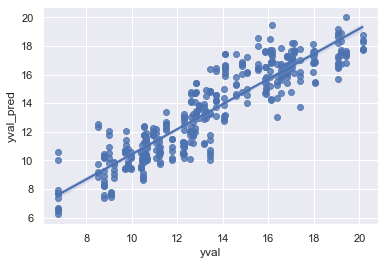

In [1519]:
import seaborn as sns
sns.set_theme()
#Calibration
sns.regplot(x='yval', y='yval_pred', data=exports_val)